In [5]:
import pandas as pd
import numpy as np

from SplineOnGPU import GPUSpline,interpolation_point_inline

In [6]:
smad_input = pd.read_csv('../../PhD/RNASeqFit/data/input_tc_trimer_simu.csv')
x = smad_input['time'].values[::20]
y = smad_input['low'].values[::20]

In [10]:
inter_x = np.sort(np.random.uniform(0,1300,(10000,100)),axis=1)

spline = GPUSpline(x,y)
inter_y = spline.eval(inter_x)

c:\Users\lripk\.conda\envs\tensorflow\lib\site-packages\numba\cuda\dispatcher.py:488: NumbaPerformanceWarning: Grid size 100 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


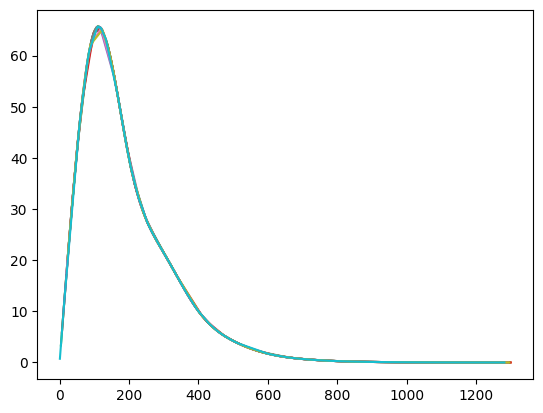

In [15]:
from numba import cuda
import matplotlib.pyplot as plt

@cuda.jit
def kernel(coef,x_array,y_array,int_pos):
    i = cuda.grid(1)
    if i < x_array.shape[0]:
        for k,dx in enumerate(x_array[i]):
            y_array[i,k] = interpolation_point_inline(coef,dx,int_pos[i])

tensor = spline.toTensor()
cuCoef = cuda.to_device(tensor)
cuInterX = cuda.to_device(inter_x)
inter_y = np.zeros_like(inter_x)
cuInterY = cuda.to_device(inter_y)
states = np.zeros(inter_x.shape[0],dtype=np.int64)
cuStates = cuda.to_device(states)

kernel[100,100](cuCoef,cuInterX,cuInterY,cuStates)
cuda.synchronize()
inter_y = cuInterY.copy_to_host()
plt.plot(inter_x[:10].T,inter_y[:10].T)
plt.show()
